# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [17]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM
import threading
import Queue


learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}

def worker(in_queue, out_queue):

    while True:
        try:
            (epocs, learning, regularization) = in_queue.get_nowait()
        except Queue.Empty:
            return

        print "worker", epocs, learning, regularization
        svm = LinearSVM()
        loss_history = svm.train(X_train_feats, y_train, learning_rate=learning, 
                                 reg=regularization, num_iters=500, verbose=True)

        y_train_pred = svm.predict(X_train_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(learning, regularization)] = (training_accuracy, validation_accuracy)
        
        out_queue.put((training_accuracy, validation_accuracy, svm))
        in_queue.task_done()
        
          
in_queue = Queue.Queue()
out_queue = Queue.Queue()
num_runs = 21
for i in range(num_runs):
    epocs = 3
    learning = 10 ** np.random.uniform(-5, 2)
    regularization = 10 ** np.random.uniform(-3, 4)
    print "Submitting epocs %d, earning %1.1e, reg %1.1e" % \
                (epocs, learning, regularization)    
    in_queue.put((epocs, learning, regularization))
   
 
    
# worker(in_queue, out_queue)
num_workers = 7
for w in range(num_workers):
    t = threading.Thread(target=worker, args=(in_queue, out_queue))
    t.daemon = True
    t.start()

in_queue.join()

best_val = -1
best_svm = None
try:
    while True:
        training_accuracy, validation_accuracy, svm = out_queue.get_nowait()
        print "res", training_accuracy, validation_accuracy, svm
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
except Queue.Empty:
    pass


# Print out results.
train_acc = []
val_acc = []
learn_rt = []
regular = []
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    learn_rt.append(lr)
    regular.append(reg)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

Submitting epocs 3, earning 1.1e-05, reg 4.6e+02
Submitting epocs 3, earning 1.2e-03, reg 4.3e-03
Submitting epocs 3, earning 1.9e-02, reg 1.5e+00
Submitting epocs 3, earning 1.0e-04, reg 1.9e+01
Submitting epocs 3, earning 7.0e-04, reg 8.0e+00
Submitting epocs 3, earning 3.4e-03, reg 3.6e+00
Submitting epocs 3, earning 8.0e+01, reg 1.6e-02
Submitting epocs 3, earning 2.5e+01, reg 7.1e+01
Submitting epocs 3, earning 4.3e-01, reg 6.6e-03
Submitting epocs 3, earning 3.0e-04, reg 4.8e+03
Submitting epocs 3, earning 1.7e-03, reg 1.6e+01
Submitting epocs 3, earning 4.0e-01, reg 2.7e+03
Submitting epocs 3, earning 1.9e-04, reg 2.6e+03
Submitting epocs 3, earning 2.1e-04, reg 1.1e-02
Submitting epocs 3, earning 3.5e+01, reg 6.5e-03
Submitting epocs 3, earning 8.1e-02, reg 4.8e-03
Submitting epocs 3, earning 1.4e-03, reg 2.0e+02
Submitting epocs 3, earning 5.4e-01, reg 8.2e+02
Submitting epocs 3, earning 1.0e-05, reg 7.6e-03
Submitting epocs 3, earning 4.5e-04, reg 1.7e-02
Submitting epocs 3, 

cs231n/classifiers/linear_classifier.py:52: RuntimeWarning: overflow encountered in multiply
  self.W += - learning_rate * grad


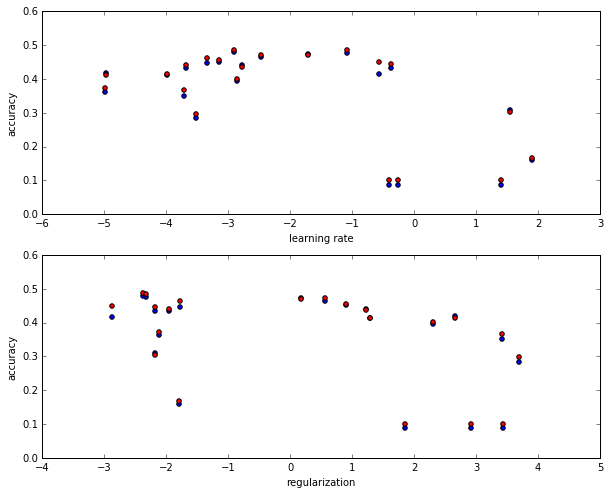

In [18]:
plt.subplot(2, 1, 1)
plt.scatter(np.log10(learn_rt), val_acc, c='b')
plt.scatter(np.log10(learn_rt), train_acc, c='r')
plt.xlabel('learning rate')
plt.ylabel('accuracy')

plt.subplot(2, 1, 2)
plt.scatter(np.log10(regular), val_acc, c='b')
plt.scatter(np.log10(regular), train_acc, c='r')
plt.xlabel('regularization')
plt.ylabel('accuracy')


plt.show()


In [10]:
print learn_rt
print val_acc

[5.094354989922173e-08, 2.323793336155037e-07, 0.010878353411599331, 0.01827769423505653]
[0.070000000000000007, 0.10299999999999999, 0.031, 0.29599999999999999]


In [19]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.475


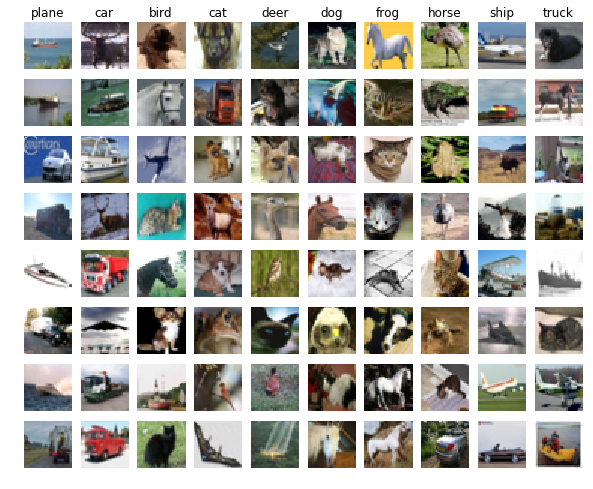

In [20]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
print X_train_feats.shape

In [29]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

def worker(queue, outlist):

    input_size = 32 * 32 * 3
    num_classes = 10
    batch_size = 200
    
    done = False
    print "starting..."
    while not done:
        try:
            epocs, hidden, learning, reg = queue.get_nowait()
            print "Starting epocs %d, hidden %d, learning %1.1e, reg %1.1e" % \
                (epocs, hidden, learning, reg)
            net = TwoLayerNet(input_dim, hidden, num_classes)
            # Train the network
            num_iters = epocs * X_train_feats.shape[0] / batch_size
            
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=num_iters, batch_size=batch_size,
            learning_rate=learning, learning_rate_decay=0.95,
            reg=reg, verbose=True)

            # Predict on the validation set
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print "epocs %d, hidden %d, learning %1.1e, reg %1.1e acc %0.5f" % \
                (epocs, hidden, learning, reg, val_acc)

            net.write_to_file()    
            outlist.append((val_acc, net))
            queue.task_done()
        except Queue.Empty:
            done = True
    print "exiting"


q = Queue.Queue()
outlist = []
num_runs = 40
for i in range(num_runs):
    epocs = 25
    hidden = np.random.uniform(20, 1000)
    learning = 10 ** np.random.uniform(-2, -0)
    reg = 10 ** np.random.uniform(-7, -3)
    print "Submitting epocs %d, hidden %d, learning %1.1e, reg %1.1e" % \
                (epocs, hidden, learning, reg)    
    q.put((epocs, hidden, learning, reg))
    

num_workers = 7
for w in range(num_workers):
    t = threading.Thread(target=worker, args=(q, outlist))
    t.daemon = True
    t.start()

q.join()
print 'Yo!'

Submitting epocs 25, hidden 206, learning 5.8e-01, reg 2.7e-05
Submitting epocs 25, hidden 589, learning 7.3e-02, reg 1.3e-06
Submitting epocs 25, hidden 996, learning 4.8e-02, reg 5.2e-07
Submitting epocs 25, hidden 806, learning 1.7e-01, reg 8.2e-05
Submitting epocs 25, hidden 771, learning 2.5e-01, reg 7.5e-06
Submitting epocs 25, hidden 945, learning 7.9e-02, reg 2.5e-05
Submitting epocs 25, hidden 764, learning 4.8e-01, reg 1.9e-05
Submitting epocs 25, hidden 985, learning 1.7e-01, reg 1.6e-07
Submitting epocs 25, hidden 308, learning 3.8e-02, reg 1.7e-07
Submitting epocs 25, hidden 437, learning 1.7e-01, reg 1.3e-06
Submitting epocs 25, hidden 404, learning 1.6e-02, reg 1.2e-04
Submitting epocs 25, hidden 595, learning 9.7e-01, reg 6.1e-07
Submitting epocs 25, hidden 423, learning 3.9e-01, reg 2.6e-05
Submitting epocs 25, hidden 237, learning 1.9e-01, reg 7.7e-06
Submitting epocs 25, hidden 530, learning 1.6e-02, reg 3.5e-07
Submitting epocs 25, hidden 46, learning 3.1e-01, reg 5

In [27]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

best_acc = -1
best_net = None
for result in outlist:
    if result[0] > best_acc:
        best_acc = result[0]
        best_net = result[1]

print best_acc, best_net

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

0.576 <cs231n.classifiers.neural_net.TwoLayerNet object at 0x7fefe64f7d10>
0.579


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!